In [1]:
#Imports
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage, misc

In [2]:
#Load images 
train_dir = 'Data/train/'
test_dir = 'Data/test/'


#Count the number of images in the different categories in training and test set
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3952      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


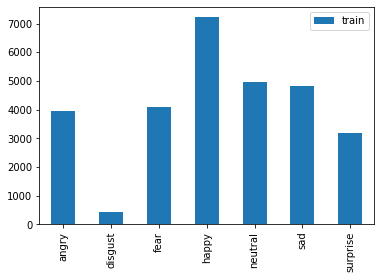

In [3]:
#Plot number of images in training set
train_count.transpose().plot(kind='bar')

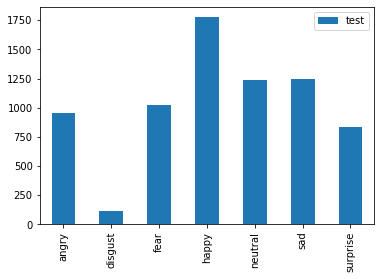

In [4]:
#Plot number of images in test set 
test_count.transpose().plot(kind='bar')

In [6]:

def load_images_from_folder(folder):
    images = []
    for expression in os.listdir(folder):
        path = folder + expression
        #print(path)
        for filename in os.listdir(path):
            #print(filename)
            img = cv2.imread(path + '/' +filename)

            if img is not None:
                images.append(img)
    return images

In [7]:
training = load_images_from_folder(train_dir)
testing = load_images_from_folder(test_dir)

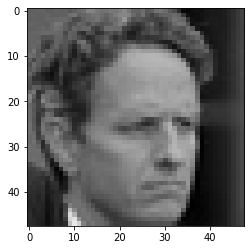

In [8]:
img = training[0]
imgplot = plt.imshow(img)
plt.show()

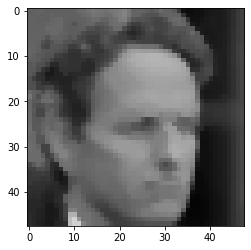

In [10]:
#Apply Median Filter
imageObject = training[0]

img_med = ndimage.median_filter(imageObject, 3)
imgplot = plt.imshow(img_med)
plt.show()


#inputs a list of images and the filtervalue (often 3)
#outputs a new list of images with the median filter applied
def apply_median_filter(images, filter_value): 
    images_med = []
    for img in images:
        img_med = ndimage.median_filter(imageObject, filter_value)
        images_med.append(img_med)
    return images_med
    

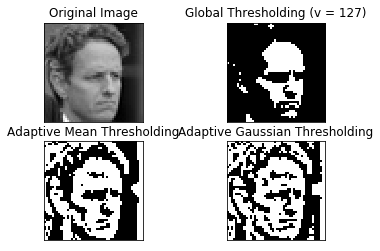

In [32]:
img = training[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()




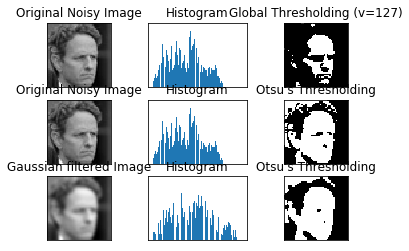

In [34]:
# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
#Apply Segmentation


In [ ]:
#Apply ROI

In [ ]:
#Apply Histogram Normalization
#https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html
